### Using a TRILEGAL file for a given healpix, produce maps with Mr - [Fe/H] priors 

Version with a subsample of the hipscat TRILEGAL catalog processed with LSDB

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
from dask.distributed import Client
pd.set_option('display.max_columns', None)

In [2]:
import os
import shutil
from collections import defaultdict

def delete_files_and_directories(directory):
    # Dictionary to store the count of each file extension
    extension_counts = defaultdict(int)
    file_count = 0
    dir_count = 0
    
    # Walk through the directory
    for root, dirs, files in os.walk(directory, topdown=False):
        # Delete files and collect their extensions
        for file in files:
            file_path = os.path.join(root, file)
            file_extension = os.path.splitext(file)[1]  # Get file extension
            extension_counts[file_extension] += 1
            os.remove(file_path)
            file_count += 1
        
        # Delete directories
        for dir in dirs:
            dir_path = os.path.join(root, dir)
            shutil.rmtree(dir_path)
            dir_count += 1
    
    # Print the results
    print(f'Total files deleted: {file_count}')
    print(f'Total directories deleted: {dir_count}')
    print('File extensions and their counts:')
    for ext, count in extension_counts.items():
        print(f'{ext}: {count}')
    
    return file_count, dir_count, dict(extension_counts)

In [3]:
client = Client(n_workers=96, threads_per_worker=1, memory_limit="auto", dashboard_address=':41987')
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:41987/status,
Dashboard: http://127.0.0.1:41987/status,Workers: 96
Total threads: 96,Total memory: 755.74 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:37385,Workers: 96
Dashboard: http://127.0.0.1:41987/status,Total threads: 96
Started: Just now,Total memory: 755.74 GiB
Comm: tcp://127.0.0.1:33701,Total threads: 1
Dashboard: http://127.0.0.1:44965/status,Memory: 7.87 GiB
Nanny: tcp://127.0.0.1:34359,


## LSDB

CPU times: user 10.6 s, sys: 3.76 s, total: 14.3 s
Wall time: 16.5 s


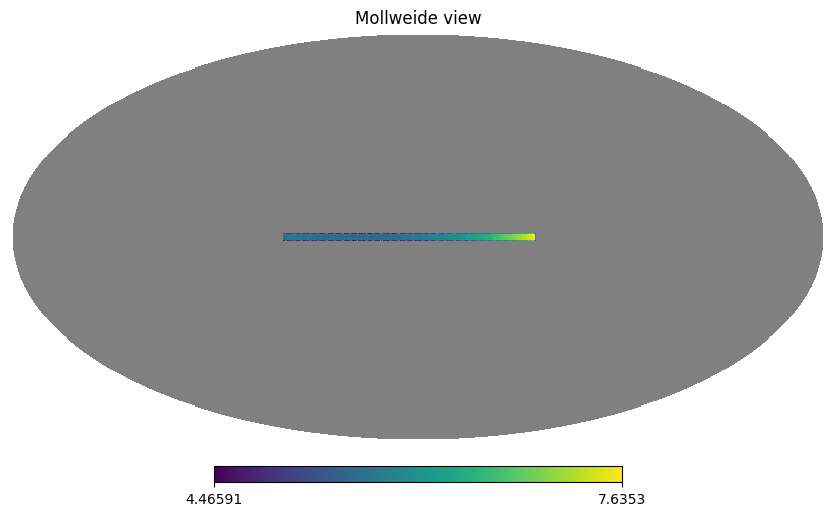

In [4]:
%%time
import lsdb
from lsdb.core.search import BoxSearch, ConeSearch, PolygonSearch
tril_fn = "/home/lovro/scratch/data/TRILEGAL_S82_fixed_hpixorder_32/trilegal_S82_32/"
tril = lsdb.read_hipscat(tril_fn, search_filter=BoxSearch(ra=(-52, 60), dec=(-1.266, 1.266)))
# tril = lsdb.read_hipscat(tril_fn, search_filter=BoxSearch(ra=(10, 30), dec=(10, 30)))
tril.skymap(lambda df, a: np.log(len(df)+1), order=9)

In [5]:
%%time

import photod.locus as lt
import photod.bayes as bt
import photod.plotting as pt
from photod.priors import dumpPriorMaps_testing

def prep(df, pix):
    subdir = f'{rootdir}/{str(pix.order)}'
    rootname = f'{subdir}/{str(pix.pixel)}'
    
    if not os.path.exists(subdir):
        os.makedirs(subdir)
        print(f'Directory created: {subdir}')
    else:
        print(f"Directory already exists: {subdir}")

    df = df.rename(columns={"gall": "glon", "galb": "glat", "gc": "comp", "m_h": "FeH", "av": "Av", "mu0": "DM"})
    trilegal = lt.readTRILEGALLSDB(df)
    trilegal['Mr'] = trilegal['rmag'] - trilegal['Ar'] - trilegal['DM']
    r = dumpPriorMaps_testing(trilegal, rootname, pix, verbose=False)
    return pd.DataFrame(data=[(pix, len(trilegal))], columns=['HealPix', 'len'])

rootdir = 'results/S82_priors'  # TODO: clean this up!

# Perform the deletion and gather statistics
delete_files_and_directories(rootdir)
tril.map_partitions(prep, include_pixel=True).compute()

Total files deleted: 4906
Total directories deleted: 2
File extensions and their counts:
.txt: 202
.npz: 4704
Directory created: results/S82_priors/0
sample <class 'nested_pandas.nestedframe.core.NestedFrame'>
Healpix:  Order: 0, Pixel: 0 
---------------------------------------
ERROR: no data to make map (see dumpPriorMaps)
ERROR: no data to make map (see dumpPriorMaps)
ERROR: no data to make map (see dumpPriorMaps)
ERROR: no data to make map (see dumpPriorMaps)
ERROR: no data to make map (see dumpPriorMaps)
ERROR: no data to make map (see dumpPriorMaps)
ERROR: no data to make map (see dumpPriorMaps)
ERROR: no data to make map (see dumpPriorMaps)
ERROR: no data to make map (see dumpPriorMaps)
ERROR: no data to make map (see dumpPriorMaps)
ERROR: no data to make map (see dumpPriorMaps)
ERROR: no data to make map (see dumpPriorMaps)
ERROR: no data to make map (see dumpPriorMaps)
ERROR: no data to make map (see dumpPriorMaps)
ERROR: no data to make map (see dumpPriorMaps)
ERROR: no data 

,HealPix,len
0,"Order: 5, Pixel: 0",40172
0,"Order: 5, Pixel: 1",127
0,"Order: 5, Pixel: 2",139
0,"Order: 5, Pixel: 3072",185692
0,"Order: 5, Pixel: 3073",563
...,...,...
0,"Order: 5, Pixel: 9214",120
0,"Order: 5, Pixel: 9215",39120
0,"Order: 5, Pixel: 12285",537
0,"Order: 5, Pixel: 12286",616


CPU times: user 29 s, sys: 12.3 s, total: 41.4 s
Wall time: 1min 58s

In [6]:
client.close()